# Introduction

In this example, we will demonstrate linear methods for classification. The dataset we are using is from Zhuo et al. J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673, but we have pre-filtered it in the following manner:
1. Only binary compounds, i.e., AxBy
2. Each element pair only has one band gap. The AxBy with the lowest formation energy per atom for each pair of A and B is retained.

In [1]:
import pandas as pd
from pymatgen import Element, Composition
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
rcparams = {'legend.fontsize': 20,
            'figure.figsize': (12, 8),
            'axes.labelsize': 24,
            'axes.titlesize': 28,
            'xtick.labelsize':20,
            'ytick.labelsize': 20}
sns.set(rc=rcparams)
mpl.rcParams.update(rcparams)

%matplotlib inline

# This sets the inline figures to high resolution for Retina display...
%config InlineBackend.figure_format ='retina'

In [2]:
binaries = pd.read_csv('binary_band_gap.csv')
# The head() method in DataFrame is useful to get a look at the 
# first few entries so that we know what the dataset looks like.
binaries.head()

,Formula,Eg (eV)
0,AgAu3,0.00
1,BaAg2,0.00
2,AgBr,2.52
3,CdAg,0.00
4,AgCl,5.13


We will use pymatgen's Composition class to create a column with an actual Compositon object.

In [3]:
binaries['composition'] = [Composition(c) for c in binaries['Formula']]

Let's create our features, which are the mean and absolute difference in electronegativities between the elements. We will also define our classes, which are metals (Eg = 0) and insulators (Eg > 0).

In [8]:
electronegs = [[el.X for el in c] for c in binaries['composition']]
binaries['mean_X'] = [np.mean(e) for e in electronegs]
binaries['diff_X'] = [max(e) - min(e) for e in electronegs]
binaries['class'] = [0 if eg < 1e-5 else 1 for eg in binaries['Eg (eV)']]
# Here, we will print out a few lines to see what our dataset looks like now.
binaries.head()

,Formula,Eg (eV),composition,mean_X,diff_X,class
0,AgAu3,0.00,"(Ag, Au)",2.235,0.61,0
1,BaAg2,0.00,"(Ba, Ag)",1.410,1.04,0
2,AgBr,2.52,"(Ag, Br)",2.445,1.03,1
3,CdAg,0.00,"(Cd, Ag)",1.810,0.24,0
4,AgCl,5.13,"(Ag, Cl)",2.545,1.23,1


Let's plot our features and dataset.

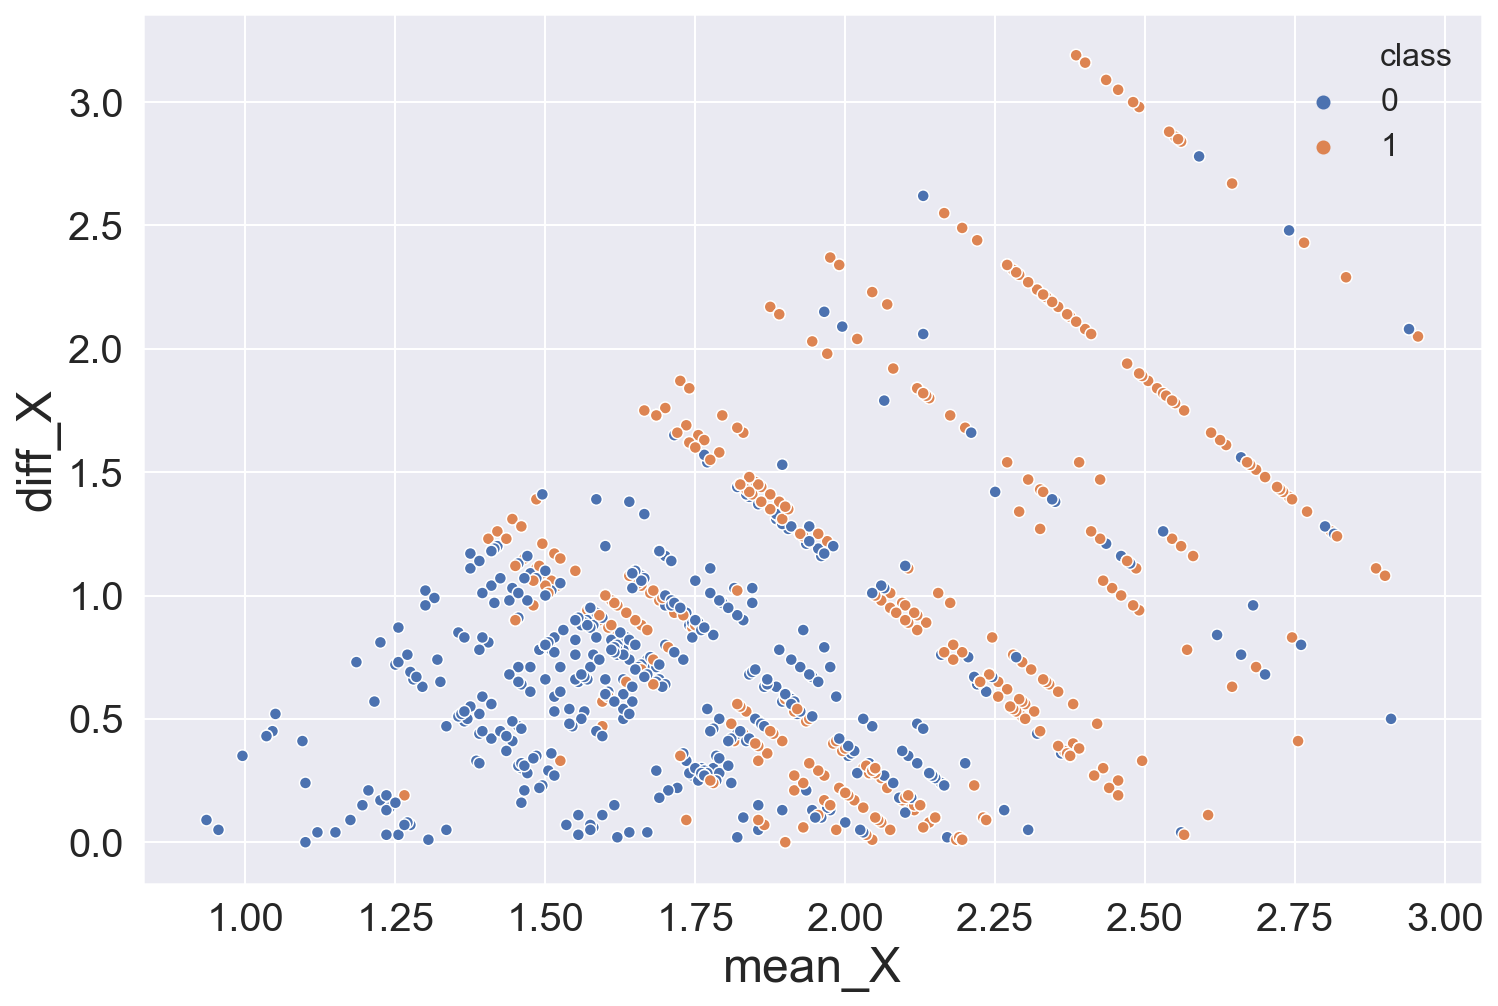

In [5]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x='mean_X', y='diff_X', hue='class', data=binaries)
plt.legend(frameon=False, fontsize=16)

# Linear Discriminant Analysis

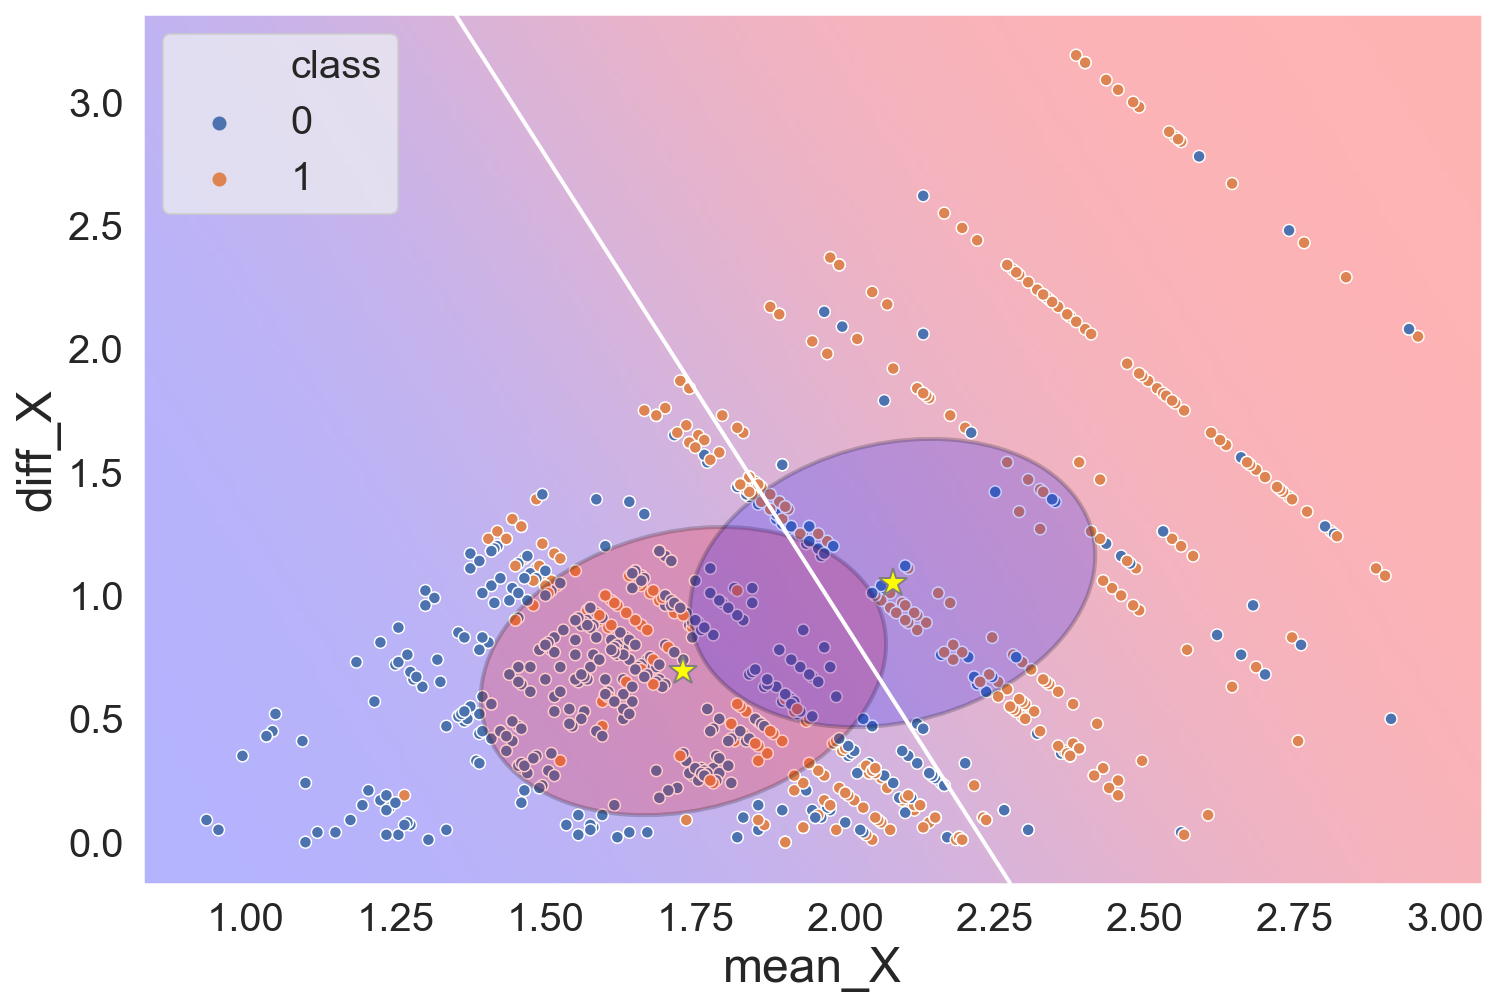

In [6]:
from scipy import linalg

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# #############################################################################
# Colormap
cmap = mpl.colors.LinearSegmentedColormap(
    'red_blue_classes',
    {'red': [(0, 1, 1), (1, 0.7, 0.7)],
     'green': [(0, 0.7, 0.7), (1, 0.7, 0.7)],
     'blue': [(0, 0.7, 0.7), (1, 1, 1)]})
plt.cm.register_cmap(cmap=cmap)


# #############################################################################
# Plot functions
def plot_data(lda, X, y, y_pred):
    sns.scatterplot(x="mean_X", y="diff_X", hue="class", data=binaries)

    # class 0 and 1 : areas
    nx, ny = 200, 100
    x_min, x_max = plt.xlim()
    y_min, y_max = plt.ylim()
    #  xx, yy creates points covering the entire 2D area
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                         np.linspace(y_min, y_max, ny))
    # Predict the probability at any point
    Z = lda.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 0].reshape(xx.shape)
    plt.pcolormesh(xx, yy, Z, cmap='red_blue_classes',
                   norm=mpl.colors.Normalize(0., 1.), zorder=0)
    # Contour plots with only one level, 0.5
    plt.contour(xx, yy, Z, [0.5], linewidths=2., colors='white')

    # means
    plt.plot(lda.means_[0][0], lda.means_[0][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')
    plt.plot(lda.means_[1][0], lda.means_[1][1],
             '*', color='yellow', markersize=15, markeredgecolor='grey')

    return plt


def plot_ellipse(splot, mean, cov, color):
    # This plots an Ellipse showing the location of the mean and covariance.
    v, w = linalg.eigh(cov)
    u = w[0] / linalg.norm(w[0])
    angle = np.arctan(u[1] / u[0])
    angle = 180 * angle / np.pi  # convert to degrees
    # filled Gaussian at 2 standard deviation
    ell = mpl.patches.Ellipse(mean, 2 * v[0] ** 0.5, 2 * v[1] ** 0.5,
                              180 + angle, facecolor=color,
                              edgecolor='black', linewidth=2)
    ax = splot.gca()
    ell.set_clip_box(ax.bbox)
    ell.set_alpha(0.2)
    ax.add_artist(ell)


plt.figure(figsize=(12, 8))
lda = LinearDiscriminantAnalysis(solver="svd", store_covariance=True)
X = binaries[["mean_X", "diff_X"]]
y = binaries["class"]
model = lda.fit(X, y)
y_pred = model.predict(X)
splot = plot_data(lda, X, y, y_pred)
plot_ellipse(splot, lda.means_[0], lda.covariance_, 'red')
plot_ellipse(splot, lda.means_[1], lda.covariance_, 'blue')

# Quadratic Discrimnant Analysis

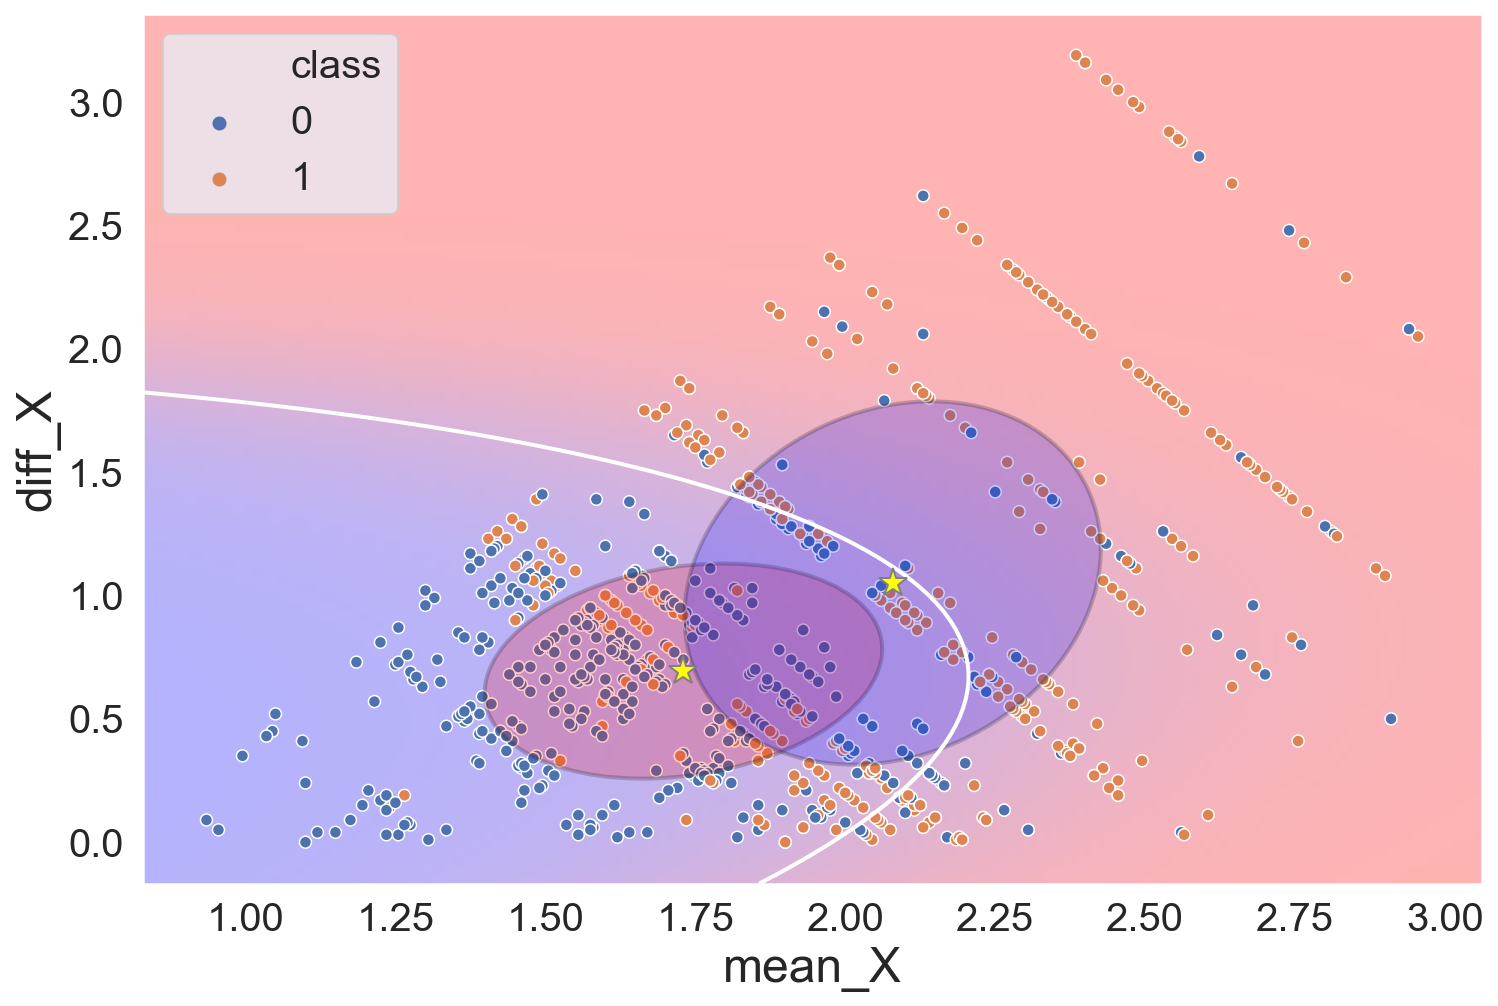

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
plt.figure(figsize=(12, 8))
qda = QuadraticDiscriminantAnalysis(store_covariance=True)
y_pred = qda.fit(X, y).predict(X)
plot = plot_data(qda, X, y, y_pred)
plot_ellipse(splot, qda.means_[0], qda.covariance_[0], 'red')
plot_ellipse(splot, qda.means_[1], qda.covariance_[1], 'blue')